In [1]:
# Set up interactive plotting using matplotlib, and load numpy
# %pylab ipympl
%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# 0: Introduction
In this notebook we will perform 3 common tasks: 

1. Obtain SMAP soil moisture data for a user-specified grid over a single date
2. Obtain SMAP soil moisture data for user-specified points over a range of dates
3. Obtain SMAP soil moisture data in its native coordinates
4. Export a pipeline for re-use elsewhere

# 00: Setup
## 00.0: Import PODPAC dependencies

In [2]:
import podpac
from podpac.datalib import smap

## 00.1: Provide Earth Data Login Credentials
If you do not have an earth data login, follow the [instructions here](https://creare-com.github.io/podpac-docs/user/earthdata.html)

In [ ]:
import getpass
username = input("Username:");   password = getpass.getpass('Password:')

## 00.2: Create the PODPAC SMAP Node

In [4]:
# Create the SMAP node
product = 'SPL4SMAU.003'   # Level 4 soil moisture analysis update
sm = smap.SMAP(product=product, interpolation='nearest', username=username, password=password)

# 1: Retrieve and plot SMAP data for:
## * A particular date
## * Over lat-lon range with user-specified grid
# 1.0: Using PODPAC

(-181.0, 181.0, -91.0, 91.0)

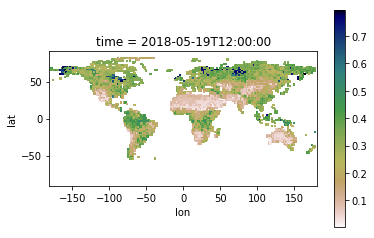

In [5]:
# dim = (start, stop, step)
lat =   (   90,  -90,-2.0)
lon =   ( -180,  180, 2.0)
# dim = value
time = '2018-05-19T12:00:00'

c_world = podpac.Coordinate(lat=lat, lon=lon, time=time)
o = sm.execute(c_world)
figure()
o.plot(cmap='gist_earth_r')
axis('scaled')

## 1.1: Let's do the same thing without using PODPAC

### 1.1.0: First create an authenticated session

In [6]:
# First create an authenticated session
import requests
class SessionWithHeaderRedirection(requests.Session):
    """
    Modified from: https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+Python
    overriding requests.Session.rebuild_auth to mantain headers when redirected
    
    Attributes
    ----------
    auth : tuple
        (username, password) string in plain text
    AUTH_HOST : str
        Host address (eg. http://example.com) that gets authenticated
    """

    AUTH_HOST = 'urs.earthdata.nasa.gov'

    def __init__(self, username=None, password=None):
        '''
        Parameters
        ------------
        username: str, optional
            Username used for authentication. 
        password: str
            Password used for authentication. 
        '''
        super(SessionWithHeaderRedirection, self).__init__()
        self.auth = (username, password)

    
    def rebuild_auth(self, prepared_request, response):
        """
        Overrides from the library to keep headers when redirected to or from
        the NASA auth host.
        """
        headers = prepared_request.headers
        url = prepared_request.url

        if 'Authorization' in headers:
            original_parsed = requests.utils.urlparse(response.request.url)
            redirect_parsed = requests.utils.urlparse(url)

            if (original_parsed.hostname != redirect_parsed.hostname) and \
                    redirect_parsed.hostname != self.AUTH_HOST and \
                    original_parsed.hostname != self.AUTH_HOST:
                del headers['Authorization']

        return

auth_session = SessionWithHeaderRedirection(username=username, password=password)

### 1.1.1: Now get the data using pydap
#### 1.1.1.0: Open the dataset and get the correct key

In [7]:
import pydap.client
# The user needs to know/construct this url. Note the version number Vv3030_001 may change unexpectedly
source = ('https://n5eil01u.ecs.nsidc.org/opendap/hyrax'
          '/SMAP/SPL4SMAU.003/2018.05.19'
          '/SMAP_L4_SM_aup_20180519T120000_Vv3030_001.h5')
# This line is needed for an initial authentication
auth_session.get(source + '.dds')  
dataset = pydap.client.open_url(source, session=auth_session)
print (str(dataset.keys).replace(',', '\n'))

<bound method Mapping.keys of <DatasetType with children 'Forecast_Data_sm_surface_forecast'
 'Forecast_Data_tb_v_forecast'
 'Forecast_Data_surface_temp_forecast'
 'Forecast_Data_tb_v_forecast_ensstd'
 'Forecast_Data_soil_temp_layer1_forecast'
 'Forecast_Data_sm_profile_forecast'
 'Forecast_Data_tb_h_forecast'
 'Forecast_Data_sm_rootzone_forecast'
 'Forecast_Data_tb_h_forecast_ensstd'
 'time'
 'Analysis_Data_sm_surface_analysis_ensstd'
 'Analysis_Data_surface_temp_analysis_ensstd'
 'Analysis_Data_sm_rootzone_analysis_ensstd'
 'Analysis_Data_sm_surface_analysis'
 'Analysis_Data_sm_profile_analysis_ensstd'
 'Analysis_Data_sm_rootzone_analysis'
 'Analysis_Data_sm_profile_analysis'
 'Analysis_Data_soil_temp_layer1_analysis'
 'Analysis_Data_soil_temp_layer1_analysis_ensstd'
 'Analysis_Data_surface_temp_analysis'
 'cell_row'
 'cell_column'
 'Observations_Data_tb_v_obs'
 'Observations_Data_tb_v_obs_time_sec'
 'Observations_Data_tb_h_obs'
 'Observations_Data_tb_h_orbit_flag'
 'Observations_Dat

### 1.1.1.1: Select the correct key and retrieve the data along with the correct coordinates

In [8]:
key = 'Analysis_Data_sm_surface_analysis'
lat_key = 'cell_lat'
lon_key = 'cell_lon'
data = dataset[key][:]
# Replace no number values with nan's
data.data[data.data == -9999] = np.nan
lat = dataset[lat_key][:]
lon = dataset[lon_key][:]
print (data.shape, lat.shape, lon.shape)

(1624, 3856) (1624, 3856) (1624, 3856)


### 1.1.2: Do a nearest neighbor interpolation onto the desired grid and plot

(-181.0, 181.0, -91.0, 91.0)

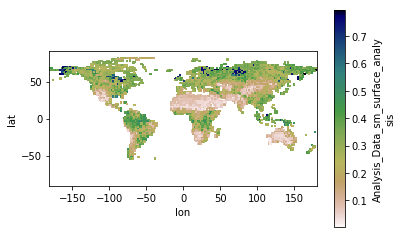

In [9]:
import xarray as xr
grid_lat = np.linspace(90, -90, 91)
grid_lon = np.linspace(-180, 180, 181)
data_arr = xr.DataArray(data, dims=['lat', 'lon'], coords=[lat[:, 0], lon[0, :]])
data_grid = data_arr.reindex({'lat': grid_lat, 'lon': grid_lon}, method='nearest')
figure()
data_grid.plot(cmap='gist_earth_r')
axis('scaled')

# 2: Retrieve and plot SMAP data for:
## * A date range
## * With user-specified lat-lon points
## 2.0: Using PODPAC

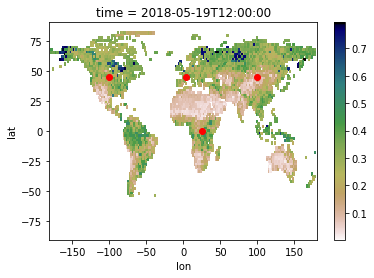

In [10]:
#               lat     lon
lat_lon_pts = [(45.0, -100.0),
               (45.0,    4.0),
               ( 0.0,   25.0),
               (45.0,  100.0)]

# Turn the list into a numpy array
lat_lon_pts = np.array(lat_lon_pts).T

# Let's plot the points
figure()
o.plot(cmap='gist_earth_r')
plot(lat_lon_pts[1], lat_lon_pts[0], 'ro')

In [11]:
c_pts = podpac.Coordinate(lat_lon=lat_lon_pts,
                         time=('2018-05-15T00', '2018-05-19T00', '3,h')
                         )
sm.threaded = True; sm.n_threads = 8
o = sm.execute(c_pts)
sm.threaded = False

([<matplotlib.axis.XTick at 0x7f40c41698d0>,
 <a list of 5 Text xticklabel objects>)

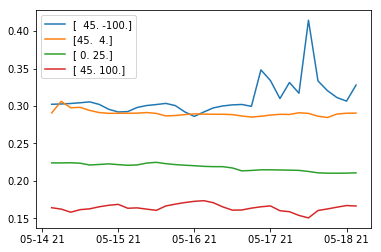

In [12]:
figure()
plot(o.time, o.data.T)
legend([str(llp) for llp in lat_lon_pts.T])
locs, labels = xticks()
xticks(locs[::2])

## 2.1: Without using PODPAC?

### 2.1.0: Find the names of the source files

In [13]:
# I'm using PODPAC to help out
date_source_inds = sm.source_coordinates.intersect(c_pts, ind=True)
date_sources = sm.sources[date_source_inds]
sources = []
for ds in date_sources:
    inds = ds.source_coordinates.intersect(c_pts, ind=True)
    sources.append(ds.sources[inds])
sources = np.concatenate(sources)
print(len(sources))
source_urls = []
for s in sources:
    source_urls.append(s.source)
    print(source_urls[-1])

34
https://n5eil01u.ecs.nsidc.org/opendap/hyrax/SMAP/SPL4SMAU.003/2018.05.14/SMAP_L4_SM_aup_20180514T210000_Vv3030_001.h5
https://n5eil01u.ecs.nsidc.org/opendap/hyrax/SMAP/SPL4SMAU.003/2018.05.14/SMAP_L4_SM_aup_20180515T000000_Vv3030_001.h5
https://n5eil01u.ecs.nsidc.org/opendap/hyrax/SMAP/SPL4SMAU.003/2018.05.15/SMAP_L4_SM_aup_20180515T030000_Vv3030_001.h5
https://n5eil01u.ecs.nsidc.org/opendap/hyrax/SMAP/SPL4SMAU.003/2018.05.15/SMAP_L4_SM_aup_20180515T060000_Vv3030_001.h5
https://n5eil01u.ecs.nsidc.org/opendap/hyrax/SMAP/SPL4SMAU.003/2018.05.15/SMAP_L4_SM_aup_20180515T090000_Vv3030_001.h5
https://n5eil01u.ecs.nsidc.org/opendap/hyrax/SMAP/SPL4SMAU.003/2018.05.15/SMAP_L4_SM_aup_20180515T120000_Vv3030_001.h5
https://n5eil01u.ecs.nsidc.org/opendap/hyrax/SMAP/SPL4SMAU.003/2018.05.15/SMAP_L4_SM_aup_20180515T150000_Vv3030_001.h5
https://n5eil01u.ecs.nsidc.org/opendap/hyrax/SMAP/SPL4SMAU.003/2018.05.15/SMAP_L4_SM_aup_20180515T180000_Vv3030_001.h5
https://n5eil01u.ecs.nsidc.org/opendap/hyrax/

### 2.1.1 Find the nearest neighbor index for lat and lon for each point

In [14]:
dataset = pydap.client.open_url(source_urls[0], session=auth_session)
key = 'Analysis_Data_sm_surface_analysis'
lat_key = 'cell_lat'
lon_key = 'cell_lon'
lat = dataset[lat_key][:]
lon = dataset[lon_key][:]

In [15]:
inds = []
for pt in lat_lon_pts.T:
    lat_ind = np.argmin(np.abs(lat[:, 0] - pt[0]))
    lon_ind = np.argmin(np.abs(lon[0, :] - pt[1]))
    inds.append((lat_ind, lon_ind))
inds

[(236, 856), (236, 1970), (811, 2195), (236, 2999)]

### 2.1.2: Loop through all the sources and retrieve the data

In [16]:
data = []
for s in source_urls:
    dataset = pydap.client.open_url(s, session=auth_session)
    date_data = [dataset[key][int(ind[0]), int(ind[1])].data.item() for ind in inds]
    data.append(date_data)

### 2.1.3: Plot the results

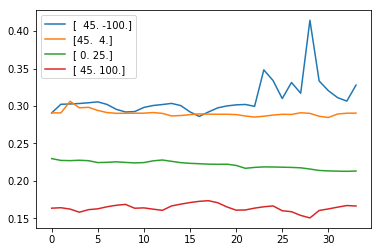

In [17]:
figure()
plot(data)
legend([str(llp) for llp in lat_lon_pts.T])

# 3: Retrieve and plot SMAP data for:
## * A particular date 
## * Over lat-lon range with underlying, native SMAP coordinates
## 3.0: Define a lat-lon bounding box for retrieving SMAP data

In [18]:
bbox = podpac.Coordinate(#dim=(start, stop, number)
                          lat=(   49,   25, 2),
                          lon=( -126,  -66, 2))

## 3.1: Get native coordinates of the SMAP data

In [19]:
# !!!!! This next line will take awhile first time it is run
sm_nc = sm.native_coordinates
sm_nc

Coordinate
	time: MonotonicCoord: Bounds[2015-03-31T03:00:00, 2018-06-05T00:00:00], N[9296], ctype["segment"]
	lat: MonotonicCoord: Bounds[-84.65644073486328, 84.65644073486328], N[1624], ctype["segment"]
	lon: MonotonicCoord: Bounds[-179.95474243164062, 179.95474243164062], N[3856], ctype["segment"]

In [20]:
# Get the SMAP native coordinates in the desired bounding box
c_intersect = sm_nc.intersect(bbox)
c_intersect.drop_dims('time')
c_intersect

Coordinate
	lat: MonotonicCoord: Bounds[24.945680618286133, 49.05809783935547], N[273], ctype["segment"]
	lon: MonotonicCoord: Bounds[-126.08280944824219, -65.96044921875], N[645], ctype["segment"]

## 3.2: Select a specific date and time

In [21]:
c = podpac.Coordinate(time='2017-04-30T21:00:00') + c_intersect
c

Coordinate
	time: MonotonicCoord: Bounds[2017-04-30T21:00:00, 2017-04-30T21:00:00], N[1], ctype["segment"]
	lat: MonotonicCoord: Bounds[24.945680618286133, 49.05809783935547], N[273], ctype["segment"]
	lon: MonotonicCoord: Bounds[-126.08280944824219, -65.96044921875], N[645], ctype["segment"]

## 3.3: Retrieve and plot the data

(-126.12966918945312,
 -65.91362762451172,
 24.906822204589844,
 49.111507415771484)

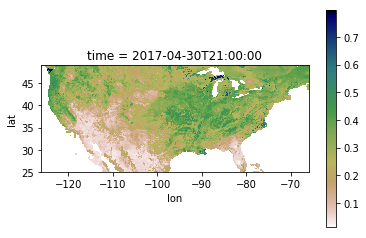

In [22]:
o = sm.execute(c)
figure()
o.plot(cmap='gist_earth_r')
axis('scaled')

# 4: Export a pipeline for re-use elsewhere

In [23]:
print(sm.pipeline_json)

{
    "nodes": {
        "SMAP_SPL4SMAU.003": {
            "node": "datalib.smap.SMAP",
            "attrs": {
                "product": "SPL4SMAU.003",
                "interpolation": "nearest",
                "n_threads": 8,
                "threaded": false
            }
        }
    },
    "outputs": [
        {
            "mode": "image",
            "format": "png",
            "vmin": -1.2,
            "vmax": 1.2,
            "nodes": [
                "SMAP_SPL4SMAU.003"
            ]
        }
    ]
}
